In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Depolarizing noise

Here we are only considering the ideal case where the noise is only present for the delay operation.

In [2]:
noise_model = NoiseModel()

p_err = 0.02
error_1q = depolarizing_error(p_err,1) # 1 qubit depolarizing error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

Preparing the circuit with $|Ψ_{in}⟩ = U_{prep}|0⟩^{⊗n}$ here $θ = \frac{\pi}{2}$

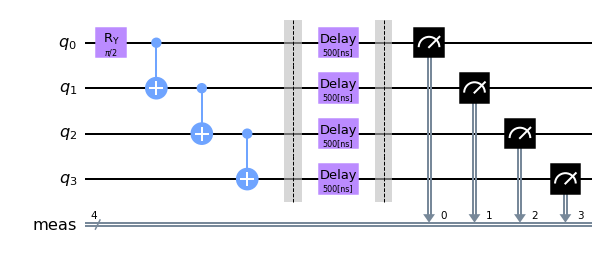

In [3]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

### Backend without noise

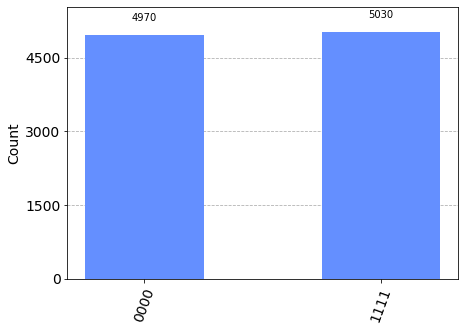

In [4]:
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)

### This is our ground truth. Everything we do from here on is to reduce the effect of noise and make $|Ψ_{out}⟩$ as close to this measurement as possible

### Backend with noise

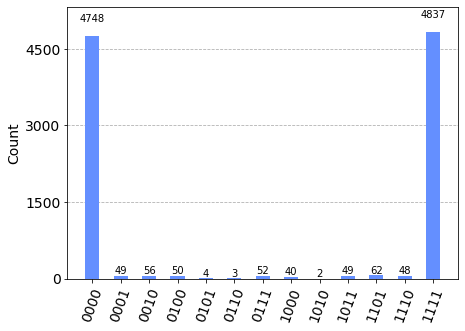

In [5]:
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

### Our goal is to apply unitary $U$ and $V$ such that the effect noise is reduced by such operation.

Here we only apply $H$ gate

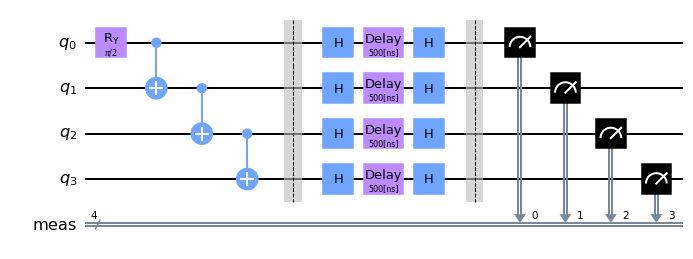

In [6]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.delay(delay,unit='ns')
  for qubit in range(n_qubits):
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


## Now measurement with noise

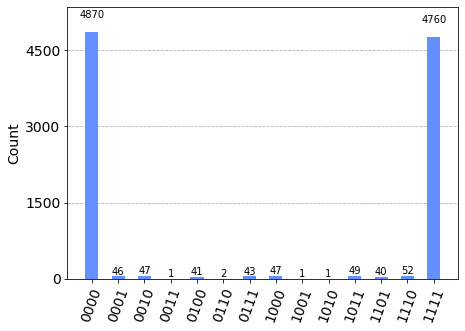

In [7]:
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

### To measure the amount of noise in all the ways we could pad the circuit, we are defining some simple cost measurement functions:

From analysis of our circuit without any noise, we see the only valid states are 
$|0000⟩\ and \ |1111⟩$

In [8]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        if (counts[state]-5000 >= 0):
            diff += (counts[state]-5000) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [9]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 30, 'error': 0.003}
Error with noise without hadamard: {'invalid_states_count': 415, 'deviation': 0, 'error': 0.0415}
Error with noise with hadamard: {'invalid_states_count': 370, 'deviation': 0, 'error': 0.037}


We can see that by padding

$U=H$ and $V=H$

has resulted in the reduction of noise

### Now we iterate over all different possible types of gates and calculate their respective errors

In [10]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

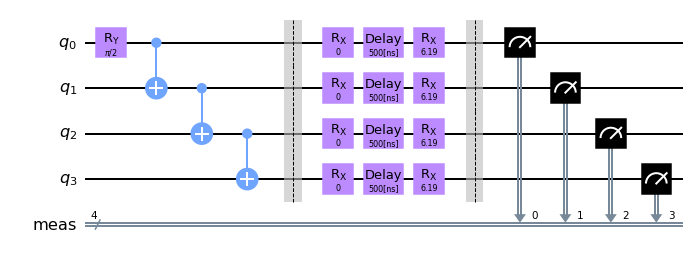

In [11]:
ckts[63][0].draw('mpl')

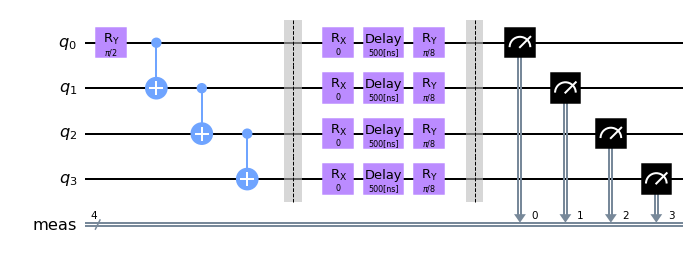

In [12]:
ckts[4100][0].draw('mpl')

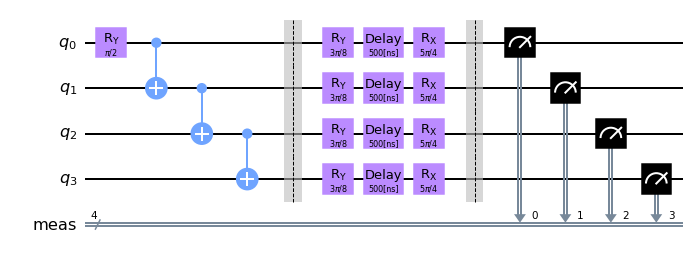

In [13]:
ckts[9000][0].draw('mpl')

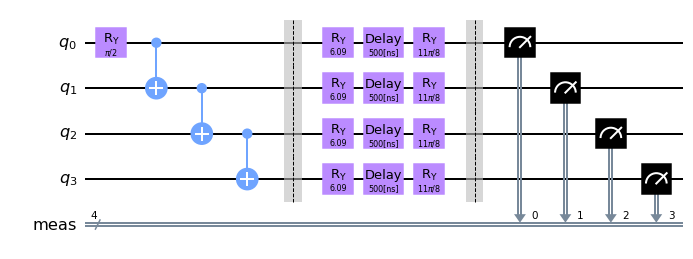

In [14]:
ckts[16300][0].draw('mpl')

### Measuring error for all the circuits and finding the circuit with least error

In [15]:
def getError(ckt_info):
  return ckt_info['error']

In [16]:
from tqdm import tqdm
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [02:13<00:00, 122.34it/s]


In [17]:
print(error[0])

{'invalid_states_count': 331, 'deviation': 0, 'error': 0.0331, 'index': 1796}


This is the optimal circuit we found

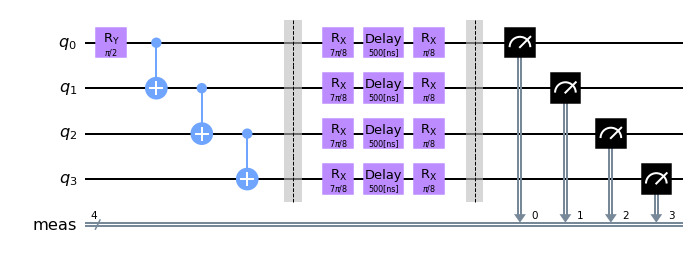

In [18]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [19]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

In [26]:
# %pip install ipympl #uncomment this line to install the plotting library

We now plot some interesting results

In [20]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )


Error without applying any gate {'invalid_states_count': 415, 'deviation': 0, 'error': 0.0415}
Error after applying hadamard gate {'invalid_states_count': 370, 'deviation': 0, 'error': 0.037}
Minimum error we found {'invalid_states_count': 331, 'deviation': 0, 'error': 0.0331, 'index': 1796}


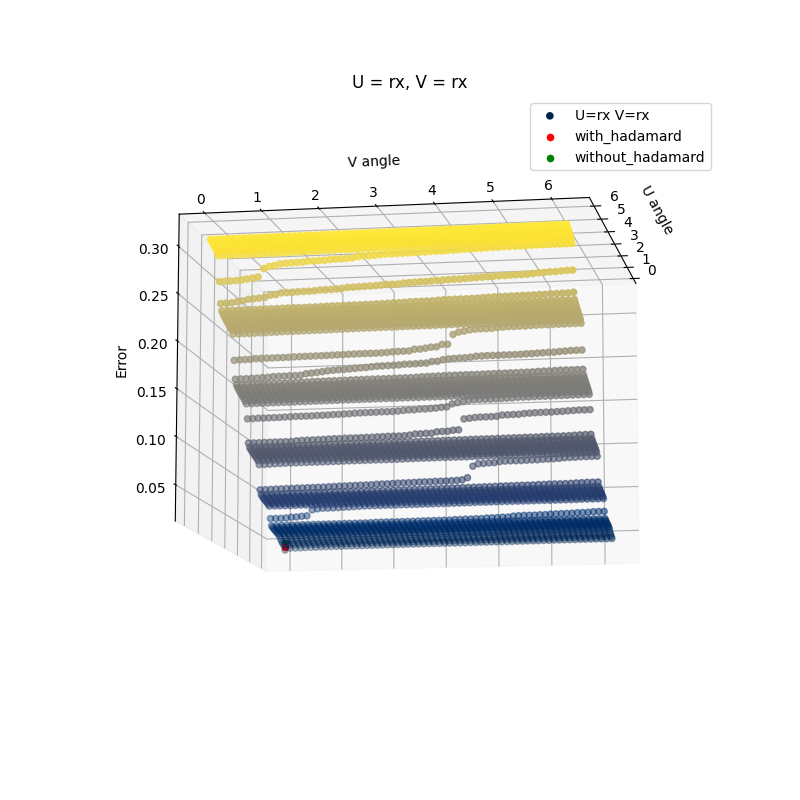

In [21]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='cividis', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 415, 'deviation': 0, 'error': 0.0415}
Error after applying hadamard gate {'invalid_states_count': 370, 'deviation': 0, 'error': 0.037}
Minimum error we found {'invalid_states_count': 331, 'deviation': 0, 'error': 0.0331, 'index': 1796}


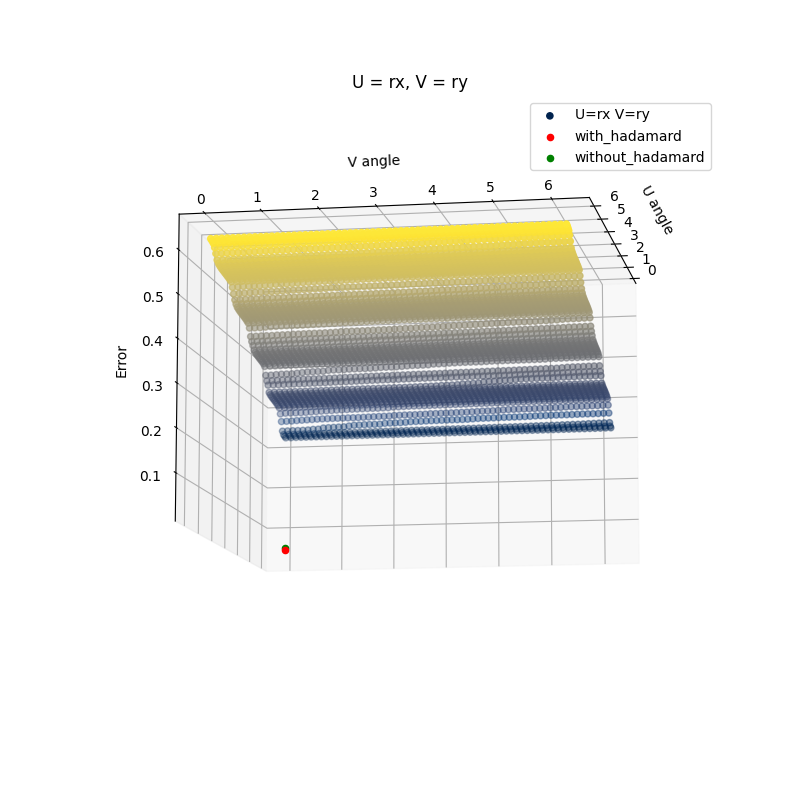

In [22]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='cividis', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 415, 'deviation': 0, 'error': 0.0415}
Error after applying hadamard gate {'invalid_states_count': 370, 'deviation': 0, 'error': 0.037}
Minimum error we found with U=ry V=rx {'invalid_states_count': 331, 'deviation': 0, 'error': 0.0331, 'index': 1796}


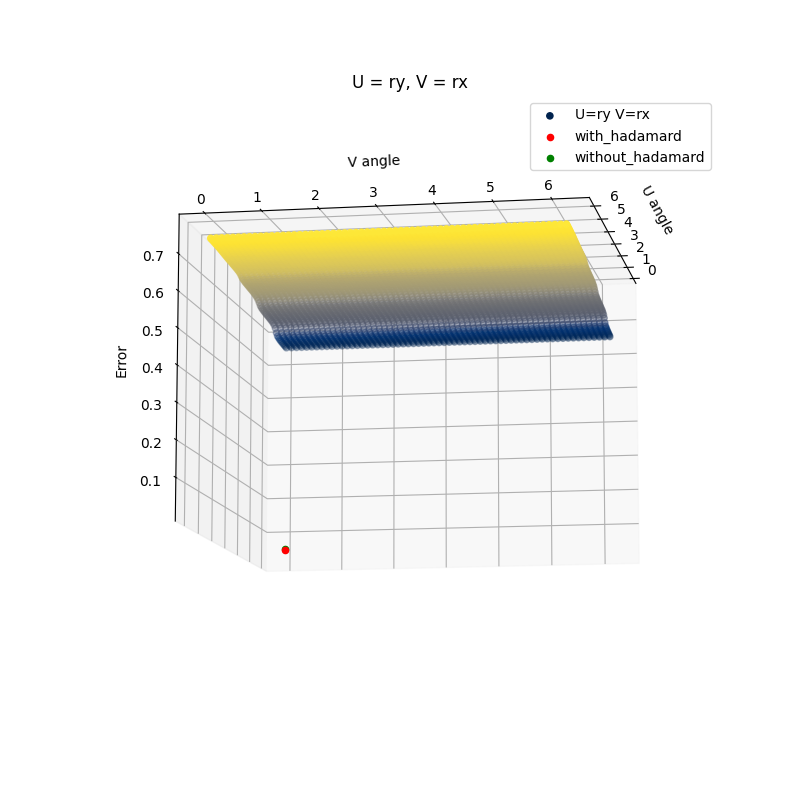

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='cividis', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 415, 'deviation': 0, 'error': 0.0415}
Error after applying hadamard gate {'invalid_states_count': 370, 'deviation': 0, 'error': 0.037}
Minimum error we found with U=ry V=rx {'invalid_states_count': 331, 'deviation': 0, 'error': 0.0331, 'index': 1796}


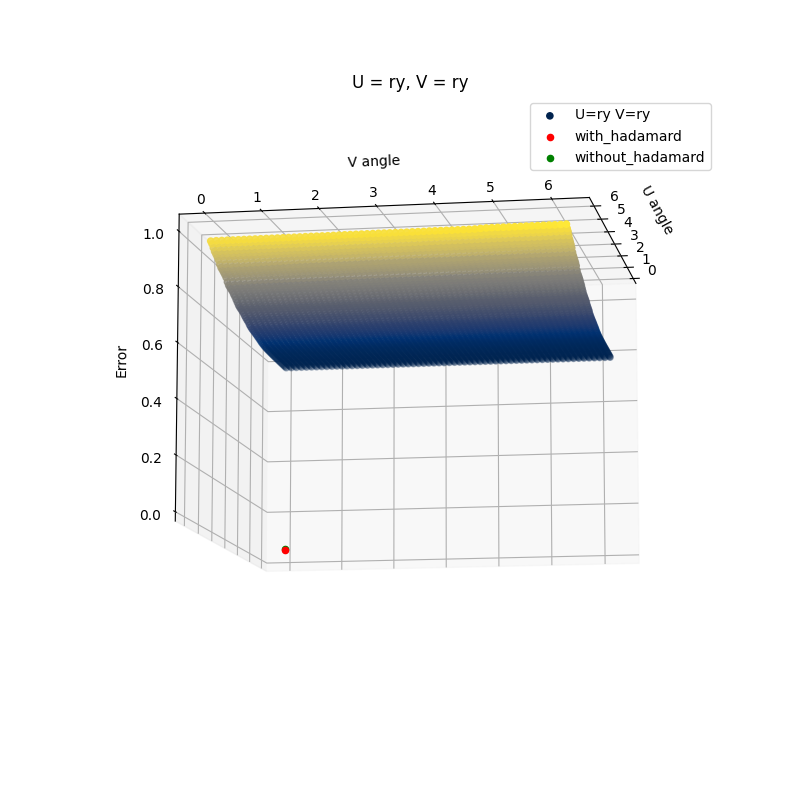

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='cividis', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

## Now we wish to change the noise model

In [25]:
from depolarization_template import depolarize as dp
min_ckt, min_err_info, min_error = dp(noise_prob=0.01, delay_time=500)

100%|██████████| 16384/16384 [02:13<00:00, 122.45it/s]


In [26]:
print(min_err_info)

{'invalid_states_count': 163, 'deviation': 0, 'error': 0.0163, 'index': 15628}


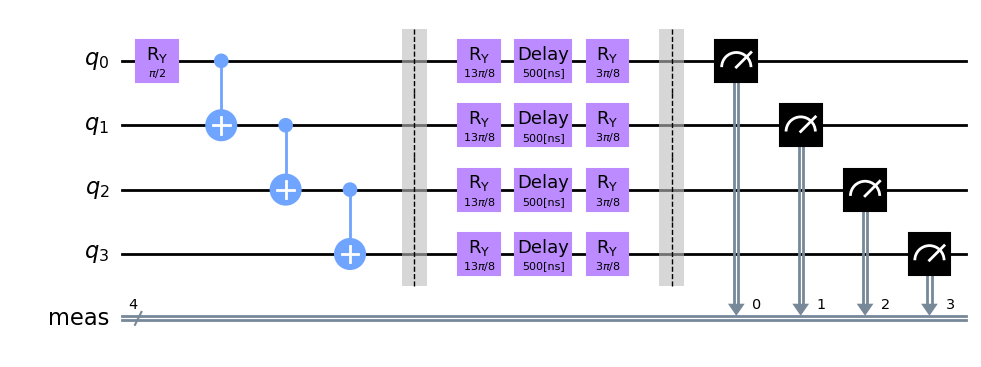

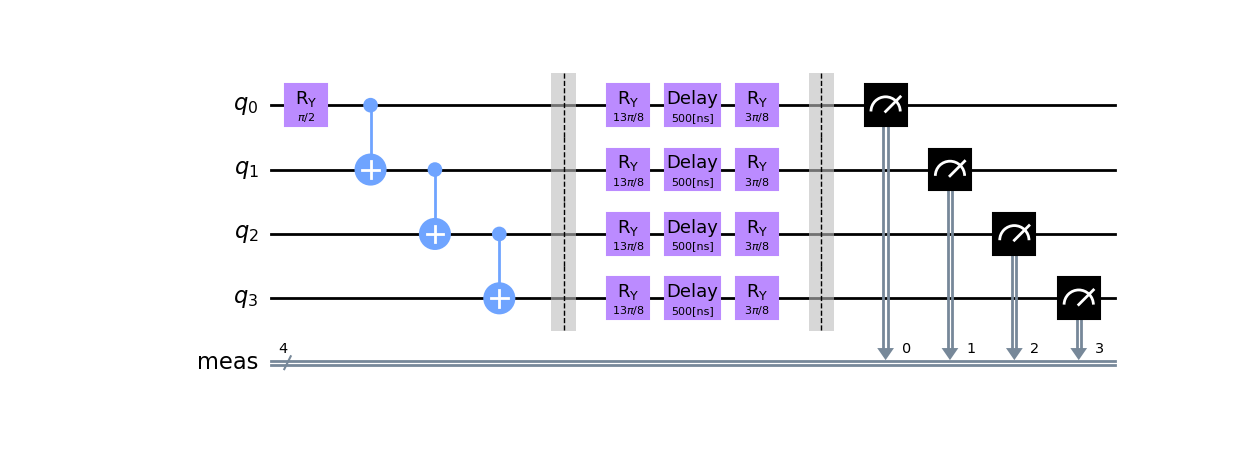

In [27]:
min_ckt.draw('mpl')

## And we run our optimal circuit with different levels of noise and delay

In [28]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []

for delay in tqdm(range(500,1200,100)):
  noise_prob = 0.005
  while(noise_prob<=0.05):
    print(f"@@@@@ noise_prob = {noise_prob} delay = {delay}")
    min_ckt, min_err_info, min_error = dp(noise_prob,delay)
    ckts_list.append(min_ckt)
    error_dict_list.append(min_err_info)
    error_list.append(min_error)
    noise_prob += 0.005

  0%|          | 0/7 [00:00<?, ?it/s]

@@@@@ noise_prob = 0.005 delay = 500


100%|██████████| 16384/16384 [02:14<00:00, 121.46it/s]


@@@@@ noise_prob = 0.01 delay = 500


100%|██████████| 16384/16384 [02:14<00:00, 121.45it/s]


@@@@@ noise_prob = 0.015 delay = 500


100%|██████████| 16384/16384 [02:15<00:00, 121.08it/s]


@@@@@ noise_prob = 0.02 delay = 500


100%|██████████| 16384/16384 [02:15<00:00, 120.88it/s]


@@@@@ noise_prob = 0.025 delay = 500


100%|██████████| 16384/16384 [02:19<00:00, 117.56it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 500


100%|██████████| 16384/16384 [02:17<00:00, 119.59it/s]


@@@@@ noise_prob = 0.035 delay = 500


100%|██████████| 16384/16384 [02:18<00:00, 118.41it/s]


@@@@@ noise_prob = 0.04 delay = 500


100%|██████████| 16384/16384 [02:16<00:00, 119.67it/s]


@@@@@ noise_prob = 0.045 delay = 500


100%|██████████| 16384/16384 [02:19<00:00, 117.43it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 500


 14%|█▍        | 1/7 [23:18<2:19:50, 1398.39s/it]

@@@@@ noise_prob = 0.005 delay = 600


100%|██████████| 16384/16384 [02:17<00:00, 119.39it/s]


@@@@@ noise_prob = 0.01 delay = 600


100%|██████████| 16384/16384 [02:18<00:00, 118.16it/s]


@@@@@ noise_prob = 0.015 delay = 600


100%|██████████| 16384/16384 [02:23<00:00, 114.18it/s]


@@@@@ noise_prob = 0.02 delay = 600


100%|██████████| 16384/16384 [02:39<00:00, 102.90it/s]


@@@@@ noise_prob = 0.025 delay = 600


100%|██████████| 16384/16384 [02:17<00:00, 119.20it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 600


100%|██████████| 16384/16384 [02:17<00:00, 119.47it/s]


@@@@@ noise_prob = 0.035 delay = 600


100%|██████████| 16384/16384 [02:18<00:00, 118.10it/s]


@@@@@ noise_prob = 0.04 delay = 600


100%|██████████| 16384/16384 [02:21<00:00, 115.49it/s]


@@@@@ noise_prob = 0.045 delay = 600


100%|██████████| 16384/16384 [02:39<00:00, 102.48it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 600


 29%|██▊       | 2/7 [47:49<2:00:06, 1441.33s/it]

@@@@@ noise_prob = 0.005 delay = 700


100%|██████████| 16384/16384 [02:14<00:00, 121.70it/s]


@@@@@ noise_prob = 0.01 delay = 700


100%|██████████| 16384/16384 [02:16<00:00, 119.87it/s]


@@@@@ noise_prob = 0.015 delay = 700


100%|██████████| 16384/16384 [02:16<00:00, 120.44it/s]


@@@@@ noise_prob = 0.02 delay = 700


100%|██████████| 16384/16384 [02:20<00:00, 116.34it/s]


@@@@@ noise_prob = 0.025 delay = 700


100%|██████████| 16384/16384 [03:21<00:00, 81.25it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 700


100%|██████████| 16384/16384 [03:57<00:00, 68.87it/s]


@@@@@ noise_prob = 0.035 delay = 700


100%|██████████| 16384/16384 [03:30<00:00, 78.00it/s]


@@@@@ noise_prob = 0.04 delay = 700


100%|██████████| 16384/16384 [02:59<00:00, 91.08it/s]


@@@@@ noise_prob = 0.045 delay = 700


100%|██████████| 16384/16384 [02:56<00:00, 92.64it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 700


 43%|████▎     | 3/7 [1:17:17<1:46:00, 1590.20s/it]

@@@@@ noise_prob = 0.005 delay = 800


100%|██████████| 16384/16384 [03:06<00:00, 87.98it/s] 


@@@@@ noise_prob = 0.01 delay = 800


100%|██████████| 16384/16384 [02:46<00:00, 98.64it/s]


@@@@@ noise_prob = 0.015 delay = 800


100%|██████████| 16384/16384 [02:50<00:00, 96.33it/s]


@@@@@ noise_prob = 0.02 delay = 800


100%|██████████| 16384/16384 [02:52<00:00, 95.21it/s]


@@@@@ noise_prob = 0.025 delay = 800


100%|██████████| 16384/16384 [02:47<00:00, 97.70it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 800


100%|██████████| 16384/16384 [02:53<00:00, 94.69it/s]


@@@@@ noise_prob = 0.035 delay = 800


100%|██████████| 16384/16384 [02:53<00:00, 94.57it/s]


@@@@@ noise_prob = 0.04 delay = 800


100%|██████████| 16384/16384 [03:05<00:00, 88.30it/s]


@@@@@ noise_prob = 0.045 delay = 800


100%|██████████| 16384/16384 [03:39<00:00, 74.64it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 800


 57%|█████▋    | 4/7 [1:48:08<1:24:40, 1693.48s/it]

@@@@@ noise_prob = 0.005 delay = 900


100%|██████████| 16384/16384 [03:20<00:00, 81.68it/s]


@@@@@ noise_prob = 0.01 delay = 900


100%|██████████| 16384/16384 [03:49<00:00, 71.39it/s]


@@@@@ noise_prob = 0.015 delay = 900


100%|██████████| 16384/16384 [03:08<00:00, 86.93it/s]


@@@@@ noise_prob = 0.02 delay = 900


100%|██████████| 16384/16384 [03:17<00:00, 82.84it/s]


@@@@@ noise_prob = 0.025 delay = 900


100%|██████████| 16384/16384 [03:26<00:00, 79.32it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 900


100%|██████████| 16384/16384 [04:03<00:00, 67.19it/s]


@@@@@ noise_prob = 0.035 delay = 900


100%|██████████| 16384/16384 [03:59<00:00, 68.50it/s]


@@@@@ noise_prob = 0.04 delay = 900


100%|██████████| 16384/16384 [04:04<00:00, 67.12it/s]


@@@@@ noise_prob = 0.045 delay = 900


100%|██████████| 16384/16384 [03:52<00:00, 70.38it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 900


 71%|███████▏  | 5/7 [2:25:48<1:03:15, 1897.54s/it]

@@@@@ noise_prob = 0.005 delay = 1000


100%|██████████| 16384/16384 [03:46<00:00, 72.29it/s]


@@@@@ noise_prob = 0.01 delay = 1000


100%|██████████| 16384/16384 [03:25<00:00, 79.86it/s]


@@@@@ noise_prob = 0.015 delay = 1000


100%|██████████| 16384/16384 [03:24<00:00, 80.12it/s]


@@@@@ noise_prob = 0.02 delay = 1000


100%|██████████| 16384/16384 [04:17<00:00, 63.62it/s]


@@@@@ noise_prob = 0.025 delay = 1000


100%|██████████| 16384/16384 [03:32<00:00, 77.10it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 1000


100%|██████████| 16384/16384 [03:23<00:00, 80.49it/s]


@@@@@ noise_prob = 0.035 delay = 1000


100%|██████████| 16384/16384 [03:25<00:00, 79.78it/s]


@@@@@ noise_prob = 0.04 delay = 1000


100%|██████████| 16384/16384 [03:42<00:00, 73.70it/s]


@@@@@ noise_prob = 0.045 delay = 1000


100%|██████████| 16384/16384 [03:55<00:00, 69.60it/s]


@@@@@ noise_prob = 0.049999999999999996 delay = 1000


 86%|████████▌ | 6/7 [3:03:02<33:32, 2012.14s/it]  

@@@@@ noise_prob = 0.005 delay = 1100


100%|██████████| 16384/16384 [03:27<00:00, 78.79it/s]


@@@@@ noise_prob = 0.01 delay = 1100


100%|██████████| 16384/16384 [03:26<00:00, 79.39it/s]


@@@@@ noise_prob = 0.015 delay = 1100


100%|██████████| 16384/16384 [03:25<00:00, 79.91it/s]


@@@@@ noise_prob = 0.02 delay = 1100


100%|██████████| 16384/16384 [03:21<00:00, 81.24it/s] 


@@@@@ noise_prob = 0.025 delay = 1100


100%|██████████| 16384/16384 [02:47<00:00, 97.90it/s]


@@@@@ noise_prob = 0.030000000000000002 delay = 1100


100%|██████████| 16384/16384 [02:47<00:00, 97.76it/s]


@@@@@ noise_prob = 0.035 delay = 1100


100%|██████████| 16384/16384 [02:47<00:00, 97.61it/s]


@@@@@ noise_prob = 0.04 delay = 1100


100%|██████████| 16384/16384 [02:47<00:00, 97.76it/s]


@@@@@ noise_prob = 0.045 delay = 1100


100%|██████████| 16384/16384 [02:46<00:00, 98.13it/s] 


@@@@@ noise_prob = 0.049999999999999996 delay = 1100


100%|██████████| 7/7 [3:34:08<00:00, 1835.56s/it]


Uncomment the lines below to save progress. Be careful the file may be large

In [32]:
ckts_list[0]

In [33]:

import pickle
data = {
'cicutes':ckts_list,
'error':error_list,
'info':error_dict_list
}

with open("depolarization.pkl", "wb") as file:
    pickle.dump(data, file)

Error after Fixing *delay*, changing error probability $p$

In [43]:
list_high = 0.05
incr = 0.005
idx = 0.005
x_axis_p_error = []
while(idx<=list_high):
    x_axis_p_error.append(round(idx, 4))
    idx += incr

list_high = 1200
incr = 100
idx = 500
x_axis_delay = []
while(idx<list_high):
    x_axis_delay.append(round(idx, 4))
    idx += incr

print(x_axis_delay, x_axis_p_error)

[500, 600, 700, 800, 900, 1000, 1100] [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]


In [67]:
len(error_list)

70

In [69]:
l_err = []

for i in range(7):
    l = []
    for j in range(10):
        l.append(error_list[i*10 + j])
    l_err.append(l)
# print(len(l_err[0]))

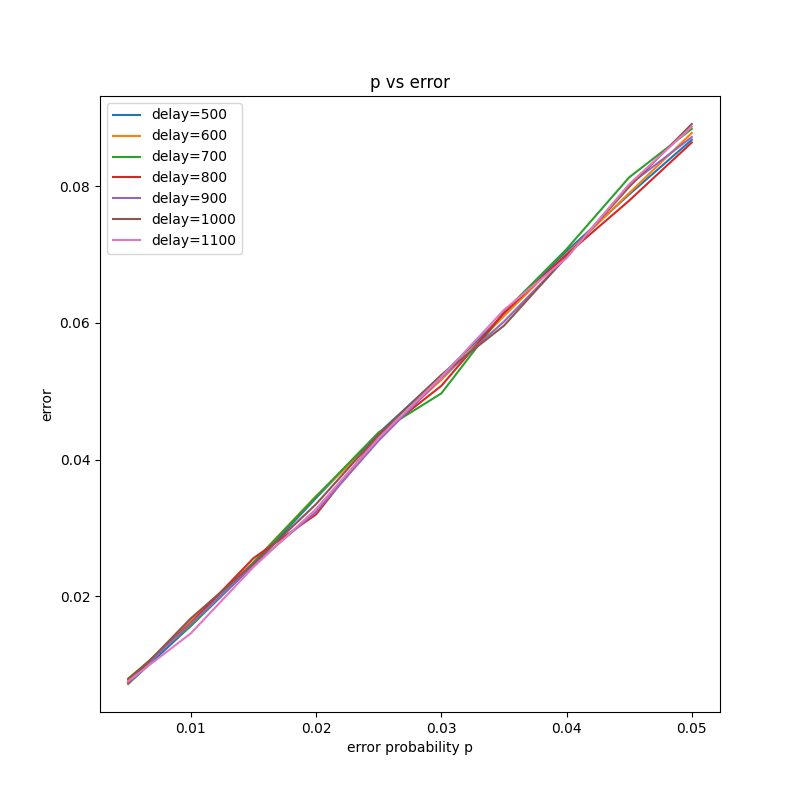

In [70]:
fig, ax = plt.subplots(figsize=(8,8))
l1 = ax.plot(x_axis_p_error, l_err[0])
l2 = ax.plot(x_axis_p_error, l_err[1])
l3 = ax.plot(x_axis_p_error, l_err[2])
l4 = ax.plot(x_axis_p_error, l_err[3])
l5 = ax.plot(x_axis_p_error, l_err[4])
l6 = ax.plot(x_axis_p_error, l_err[5])
l7 = ax.plot(x_axis_p_error, l_err[6])
# l8 = ax.plot(x_axis_p_error, l_err[7])
# l9 = ax.plot(x_axis_p_error, l_err[8])
# l10 = ax.plot(x_axis_p_error, l_err[9])


ax.legend(['delay=500','delay=600','delay=700','delay=800','delay=900','delay=1000','delay=1100'])
ax.set_xlabel('error probability p')
ax.set_ylabel('error')
ax.set_title('p vs error')
plt.show()

In [71]:
l_err = []

for i in range(10):
    l = []
    for j in range(7):
        l.append(error_list[j*10 + i])
    l_err.append(l)
# print(l_err)

In [72]:
l_err

[[0.0072, 0.0073, 0.008, 0.0078, 0.0076, 0.0074, 0.0076],
 [0.0157, 0.0165, 0.0157, 0.0161, 0.016, 0.0168, 0.0146],
 [0.0246, 0.025, 0.025, 0.0256, 0.0246, 0.0248, 0.0243],
 [0.0344, 0.0347, 0.0346, 0.032, 0.0324, 0.0335, 0.0328],
 [0.0439, 0.0433, 0.044, 0.0436, 0.0428, 0.0437, 0.0432],
 [0.0523, 0.0517, 0.0497, 0.0508, 0.052, 0.0524, 0.0521],
 [0.0612, 0.061, 0.0616, 0.0615, 0.0602, 0.0596, 0.0619],
 [0.0705, 0.0701, 0.0708, 0.07, 0.0696, 0.0697, 0.0695],
 [0.0788, 0.079, 0.0813, 0.0779, 0.0802, 0.0799, 0.0803],
 [0.0868, 0.0878, 0.0884, 0.0864, 0.0872, 0.0891, 0.0887]]

Error after fixing error probability *p*, changing delay 

/var/folders/gq/309vcw9507z_fp220k0ltqy80000gn/T/ipykernel_79434/1841013915.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,8))


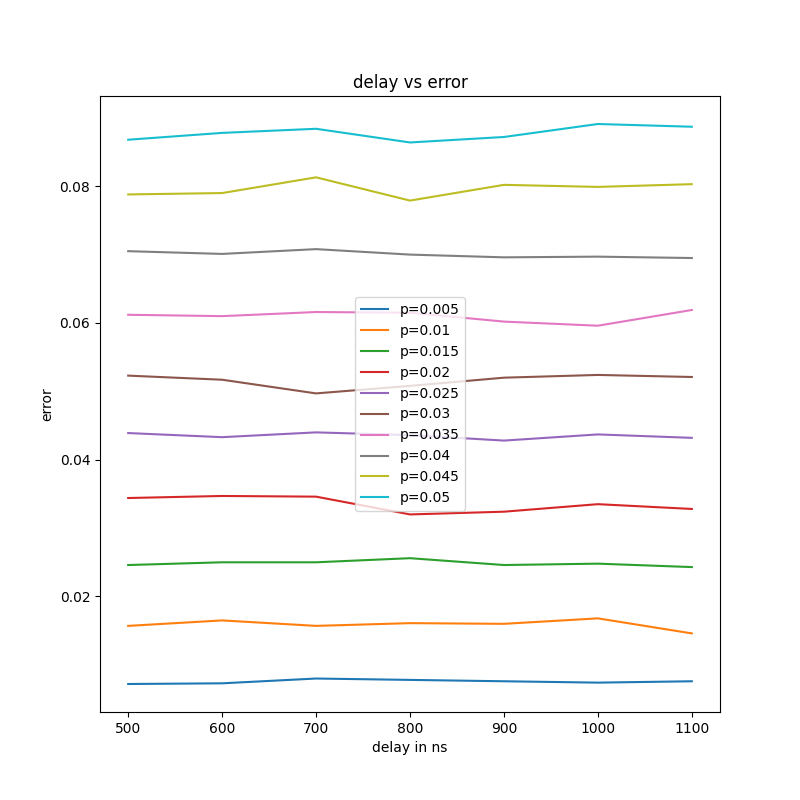

In [73]:
fig, ax = plt.subplots(figsize=(8,8))

l1 = ax.plot(x_axis_delay, l_err[0])
l2 = ax.plot(x_axis_delay, l_err[1])
l3 = ax.plot(x_axis_delay, l_err[2])
l4 = ax.plot(x_axis_delay, l_err[3])
l5 = ax.plot(x_axis_delay, l_err[4])

l6 = ax.plot(x_axis_delay, l_err[5])
l7 = ax.plot(x_axis_delay, l_err[6])
l8 = ax.plot(x_axis_delay, l_err[7])
l9 = ax.plot(x_axis_delay, l_err[8])
l10 = ax.plot(x_axis_delay, l_err[9])


#[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
ax.legend(['p=0.005','p=0.01','p=0.015','p=0.02','p=0.025','p=0.03','p=0.035', 'p=0.04', 'p=0.045', 'p=0.05'])
ax.set_xlabel('delay in ns')
ax.set_ylabel('error')
ax.set_title('delay vs error')
plt.show()

### Plotting some of the minimum error circuits with some particular value of delay and $p$

In [52]:
len(ckts_list) ## For each delay, and each error probability

70

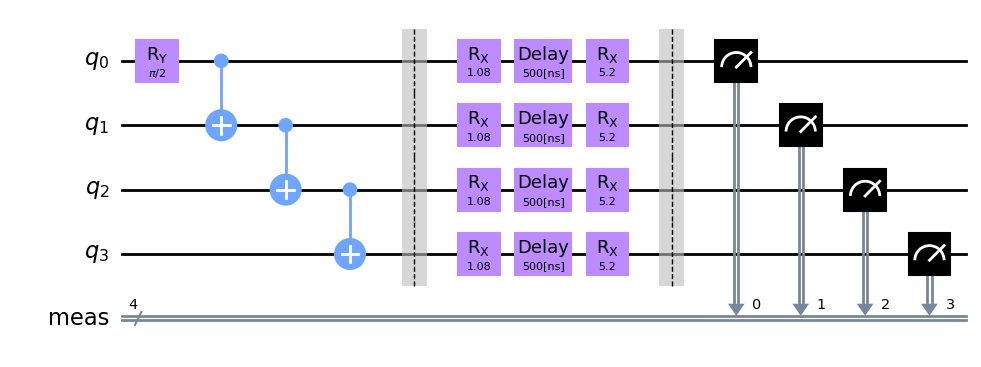

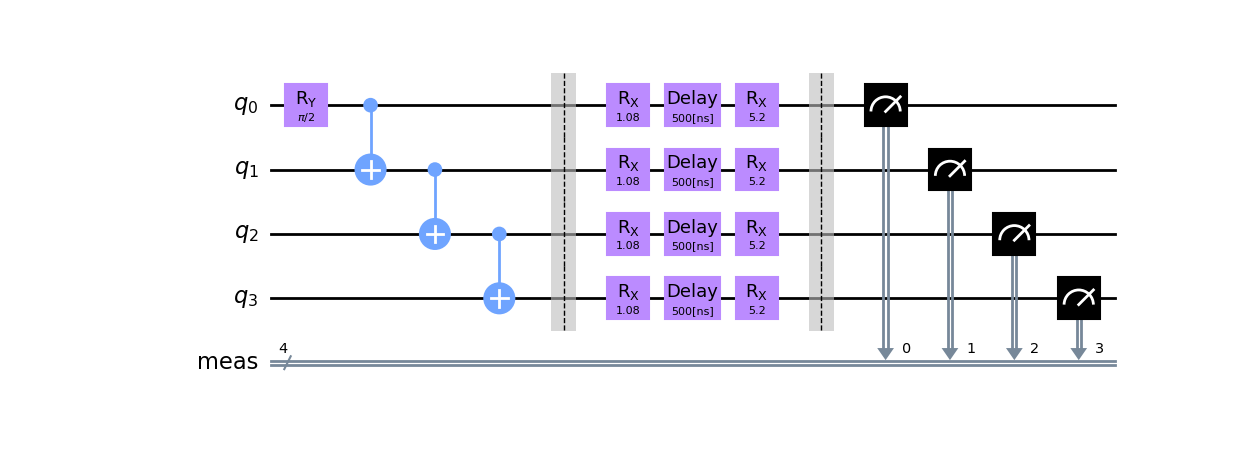

In [74]:
ckts_list[0].draw('mpl')

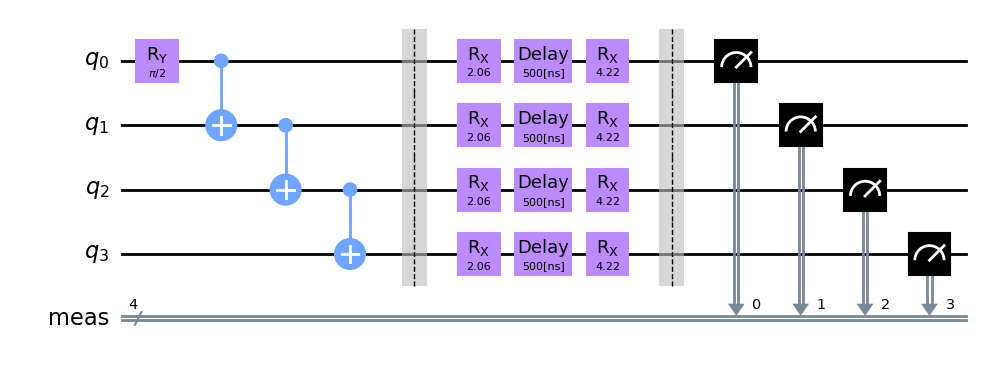

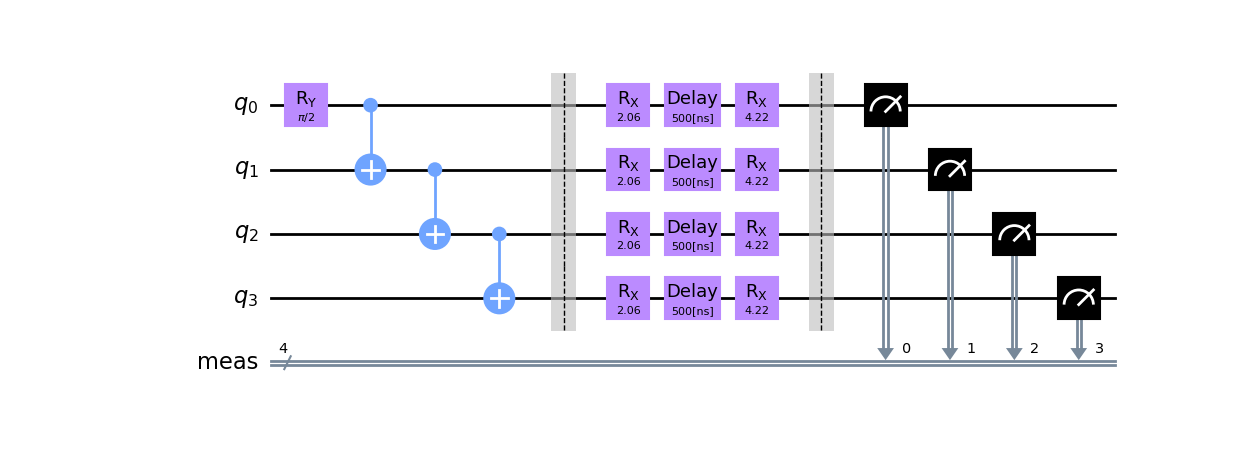

In [54]:
ckts_list[1].draw('mpl')

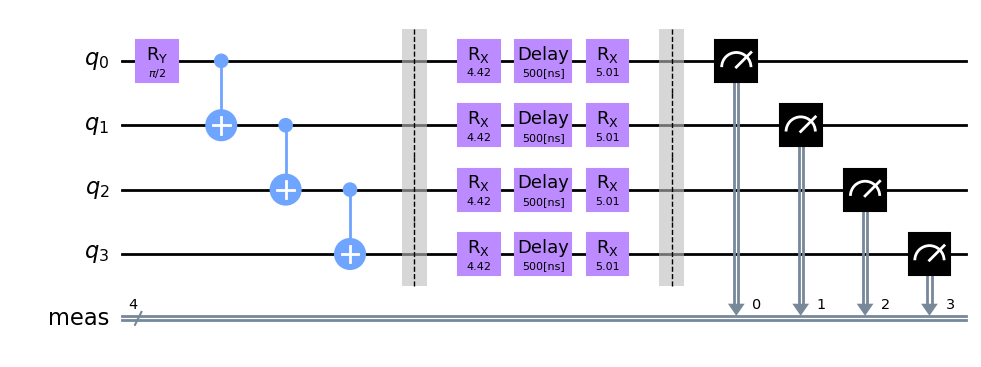

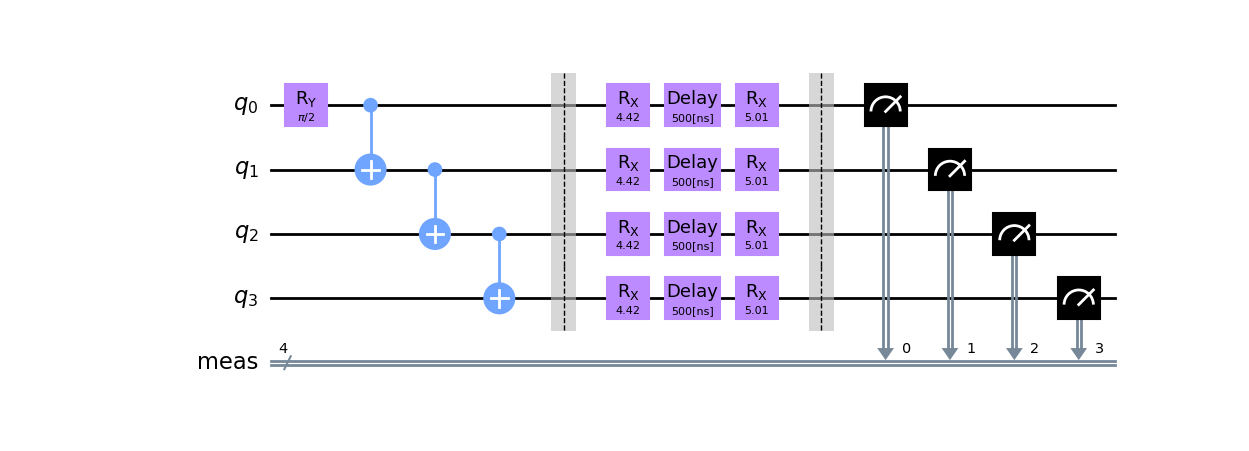

In [55]:
ckts_list[3].draw('mpl')

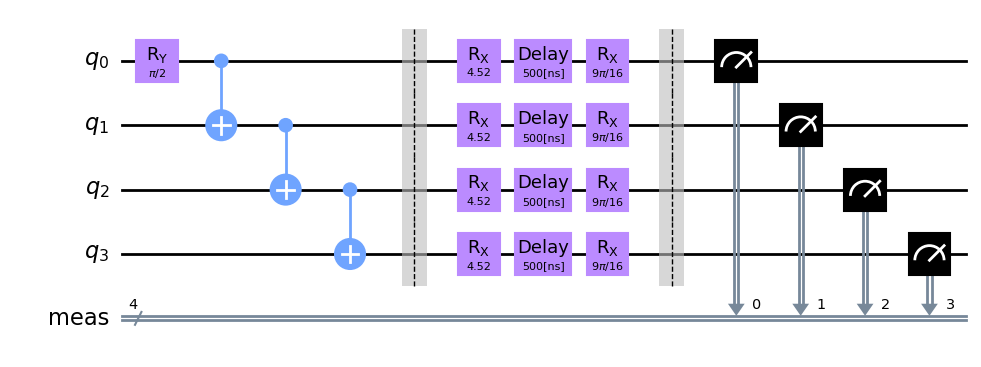

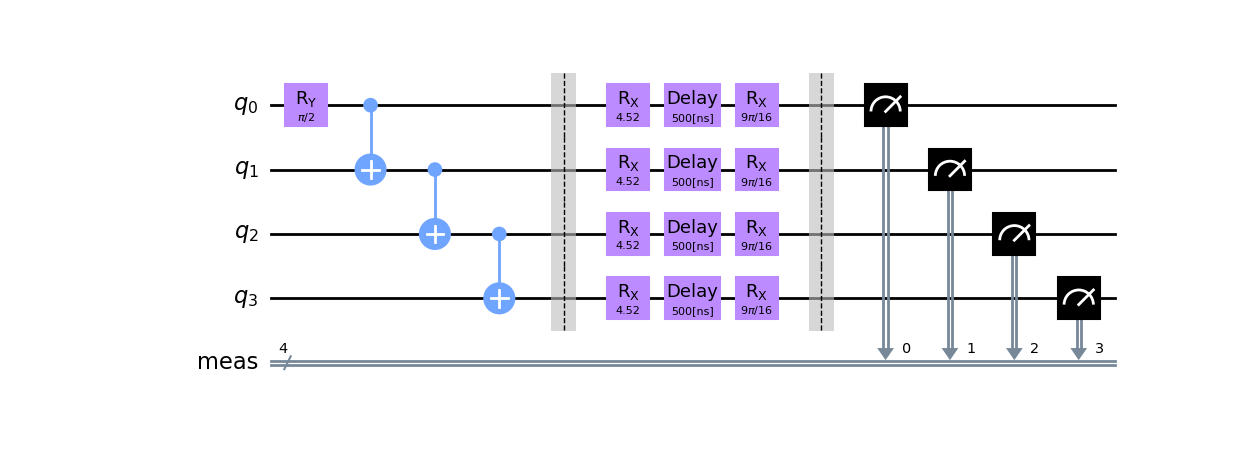

In [56]:
ckts_list[4].draw('mpl')

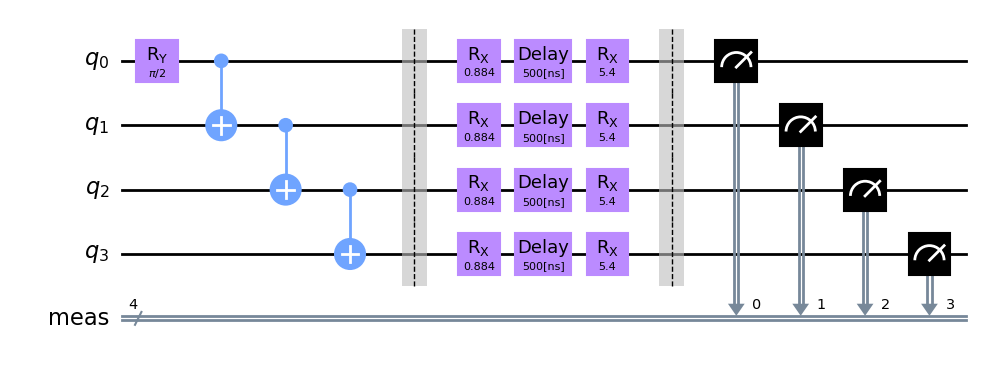

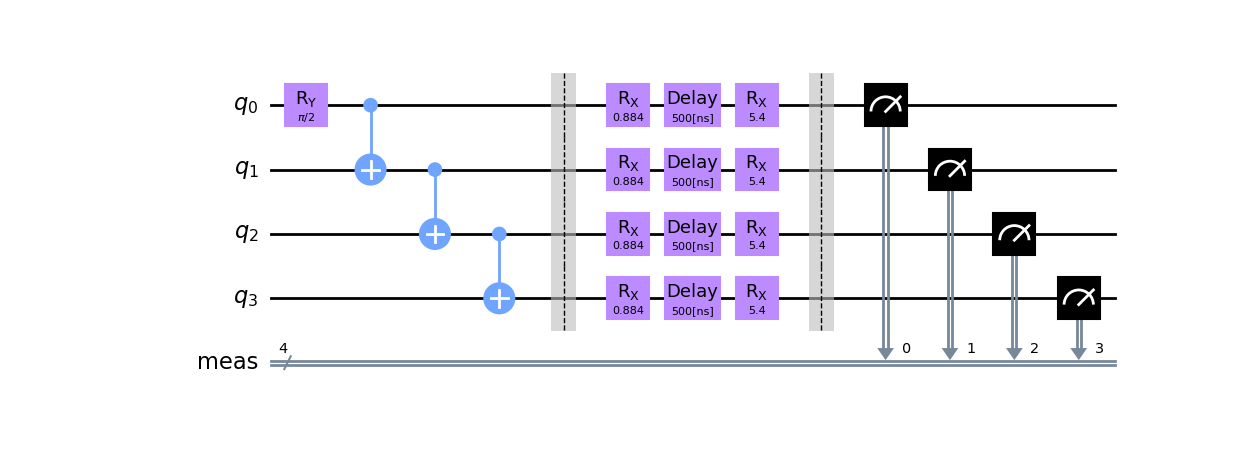

In [57]:
ckts_list[5].draw('mpl')

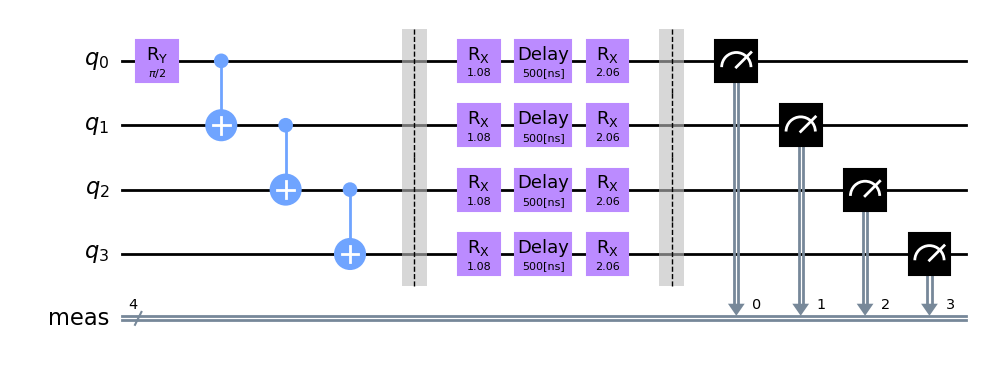

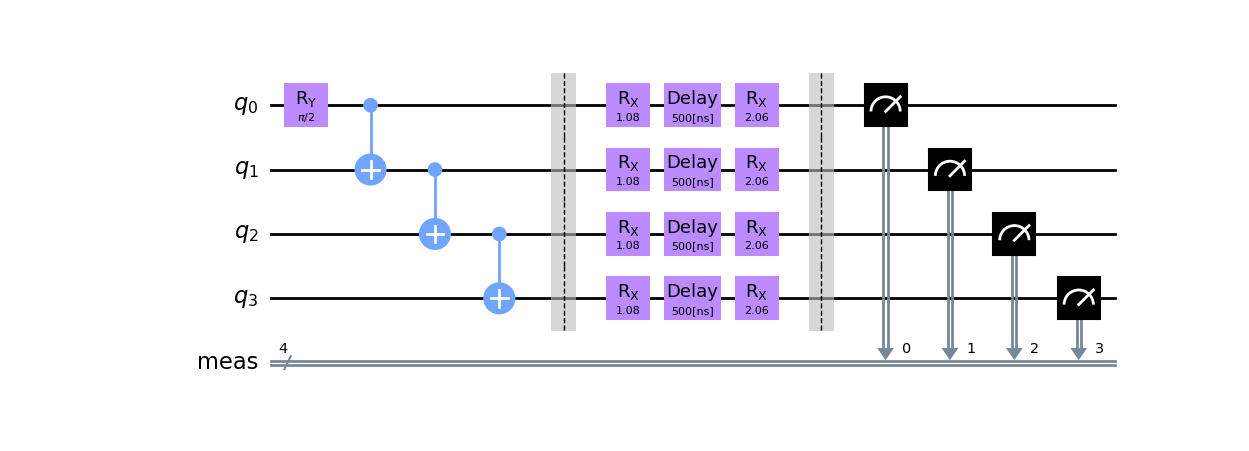

In [58]:
ckts_list[6].draw('mpl')

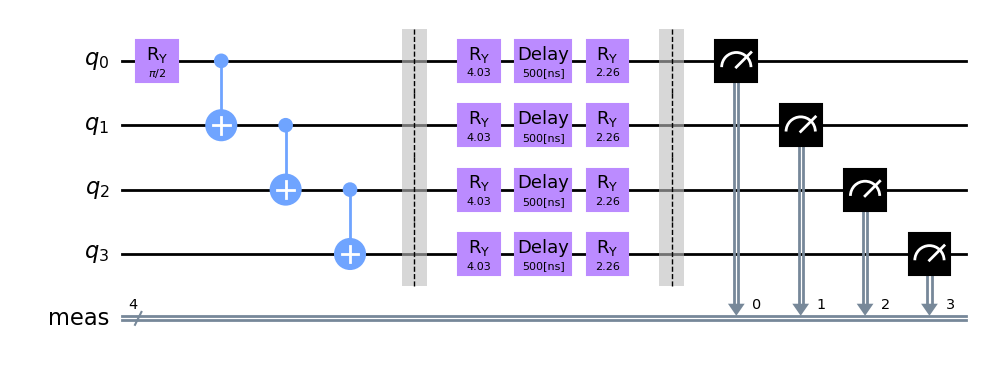

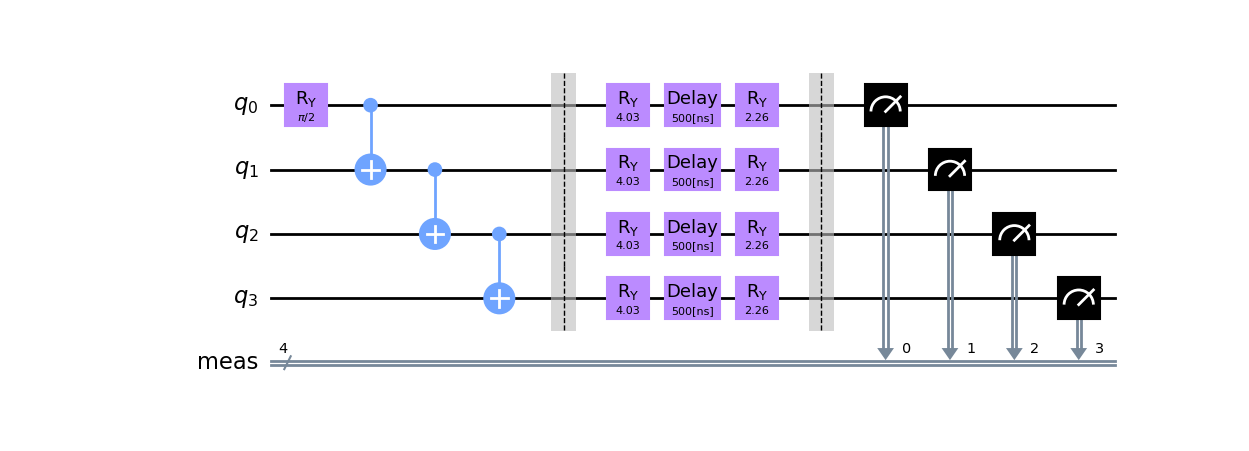

In [62]:
ckts_list[7].draw('mpl')

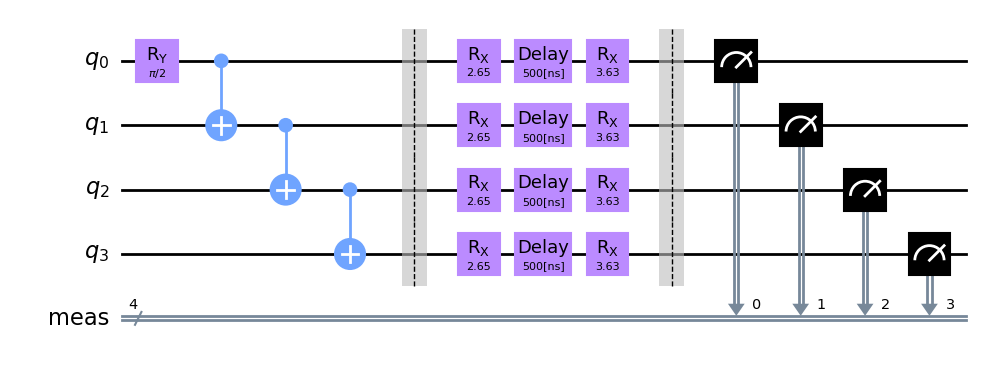

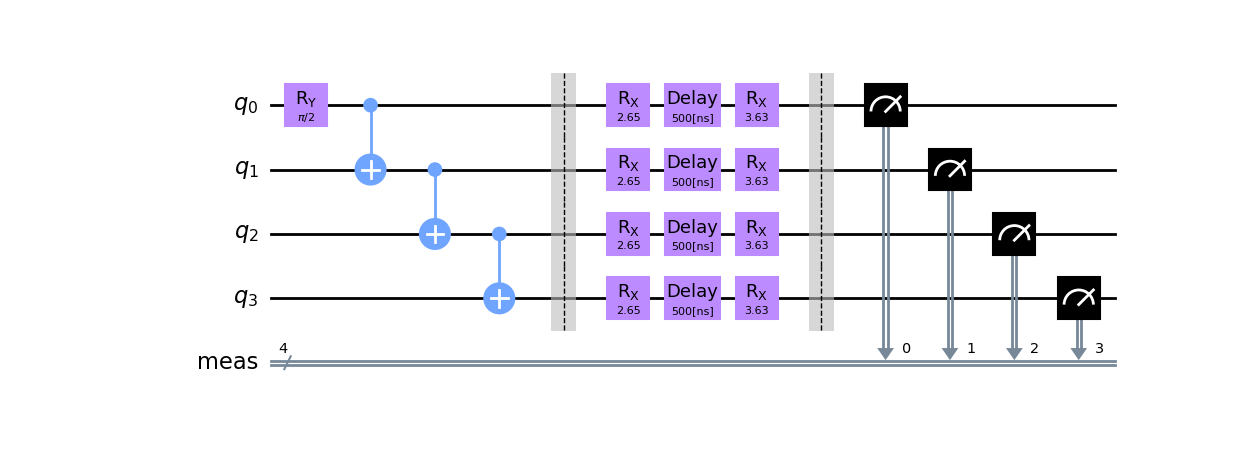

In [63]:
ckts_list[8].draw('mpl')

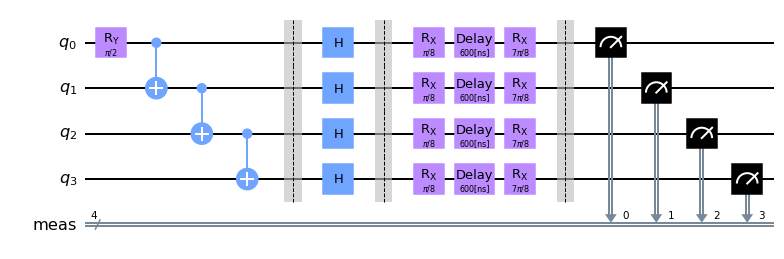

In [178]:
min_err_ckt_list[9].draw('mpl')

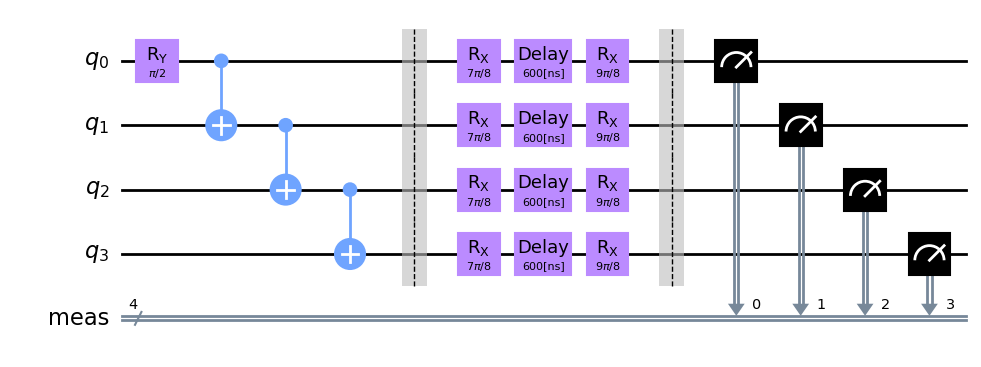

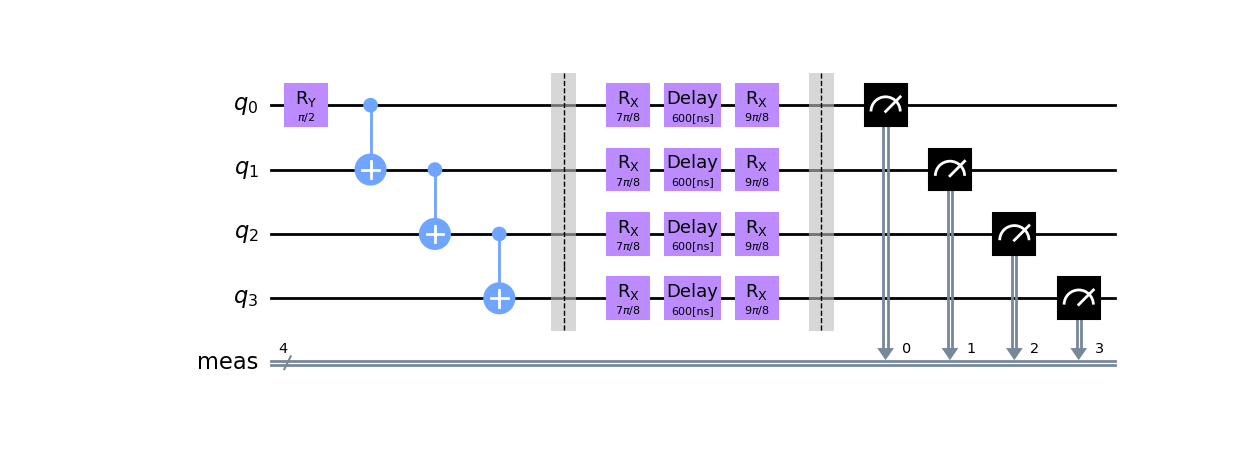

In [64]:
ckts_list[10].draw('mpl')

In [65]:
%qiskit_version_table